In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.linear import UnaryLinear
from UnarySim.sw.stream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def linear_test(rng="Sobol", in_feature=128, out_feature=10000, bitwidth=8, bias=True):
    modes = ["bipolar", "unipolar"]
    bstype = torch.float
    buftype = torch.float
    randtype = torch.float
    scaled = [True, False]
    result_pe = []
    
    for mode in modes:
        for scale in scaled:
            length = 2**bitwidth
            result_pe_cycle = []
            fc = torch.nn.Linear(in_feature, out_feature, bias=bias).to(device)
            
            if mode is "unipolar":
                fc.weight.data = torch.rand(out_feature, in_feature).mul(length).round().div(length).to(device)
                if bias is True:
                    fc.bias.data = torch.rand(1, out_feature).mul(length).round().div(length).to(device)
            elif mode is "bipolar":
                fc.weight.data = torch.rand(out_feature, in_feature).mul(2).sub(1).mul(length).round().div(length).to(device)
                if bias is True:
                    fc.bias.data = torch.rand(1, out_feature).mul(2).sub(1).mul(length).round().div(length).to(device)

            ufc = UnaryLinear(in_feature, out_feature, fc.weight, fc.bias, 
                              bitwidth=bitwidth, mode=mode, scaled=scale, bias=bias, 
                              bstype=bstype, buftype=buftype, randtype=randtype).to(device)

            iVec = ((torch.rand(1, in_feature)*length).round()/length).to(device)
            oVec = fc(iVec)

            iVecSource = SourceGen(iVec, bitwidth=bitwidth, mode=mode, randtype=randtype)().to(device)
            iVecRNG = RNG(bitwidth, 1, rng, randtype=randtype)().to(device)
            iVecBS = BSGen(iVecSource, iVecRNG, bstype=bstype).to(device)

            iVecPE = ProgressiveError(iVec, mode=mode).to(device)
            
            if scale is True:
                if bias == 0:
                    oVecPE = ProgressiveError(oVec, scale=in_feature, mode=mode).to(device)
                elif bias ==1:
                    oVecPE = ProgressiveError(oVec, scale=in_feature+1, mode=mode).to(device)
            else:
                oVecPE = ProgressiveError(oVec, scale=1, mode=mode).to(device)
            
            with torch.no_grad():
                idx = torch.zeros(iVecSource.size()).type(torch.long).to(device)
                start_time = time.time()
                for i in range(length):
                    iBS = iVecBS(idx + i)
                    iVecPE.Monitor(iBS)

                    oVecU = ufc(iBS)
                    oVecPE.Monitor(oVecU)
                    if bias is False:
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/out_feature).item())
                    else:
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/(out_feature+1)).item())
                print("--- %s seconds ---" % (time.time() - start_time))
                print("input error: ", "min:", torch.min(iVecPE()[1]).item(), "max:", torch.max(iVecPE()[1]).item())
                print("output error: ", "min:", torch.min(oVecPE()[1]).item(), "max:", torch.max(oVecPE()[1]).item(), "RMSE: ", torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/out_feature).item())
                result_pe = oVecPE()[1][0].cpu().numpy()
                print("error distribution=========>")
                plt.figure(figsize=(3,1.5))
                fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
                plt.title("data: "+mode+", scaled: "+str(scale))
                plt.show()
                print("progressive accuracy=========>")
                plt.figure(figsize=(3,1.5))
                fig = plt.plot(result_pe_cycle)  # arguments are passed to np.histogram
                plt.title("data: "+mode+", scaled: "+str(scale))
                plt.show()
                

--- 0.8710002899169922 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.010191027075052261 max: -0.0009665684192441404 RMSE:  0.006143542472273111
error distribution=========>


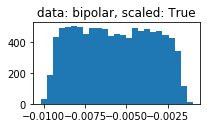

progressive accuracy=========>


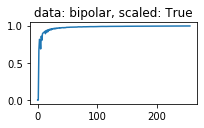

--- 0.8309998512268066 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -1.3665771484375 max: 0.1015625 RMSE:  0.3288499116897583
error distribution=========>


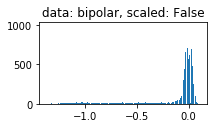

progressive accuracy=========>


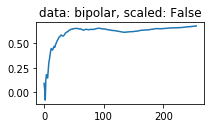

--- 0.5559995174407959 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: -0.005698606371879578 max: -0.001397252082824707 RMSE:  0.0036944393068552017
error distribution=========>


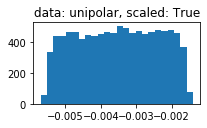

progressive accuracy=========>


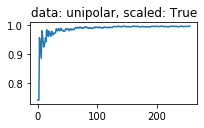

--- 0.5509979724884033 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: 0.0 max: 0.0 RMSE:  0.0
error distribution=========>


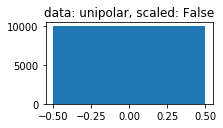

progressive accuracy=========>


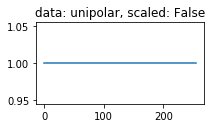

In [5]:
rng = "Sobol"
in_feature = 512
out_feature = 10000
bitwidth = 8
bias = True
linear_test(rng, in_feature, out_feature, bitwidth, bias)

--- 0.8199996948242188 seconds ---
input error:  min: -0.01171875 max: 0.00390625
output error:  min: -0.01080583967268467 max: -0.0012528863735496998 RMSE:  0.0064982143230736256
error distribution=========>


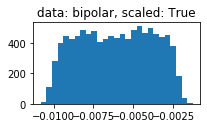

progressive accuracy=========>


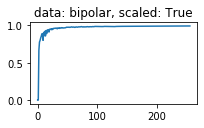

--- 0.8389999866485596 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -1.2403106689453125 max: 0.3515625 RMSE:  0.3178246021270752
error distribution=========>


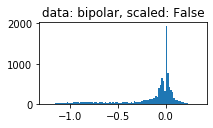

progressive accuracy=========>


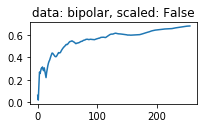

--- 0.5410029888153076 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: -0.006840869784355164 max: -0.0025707781314849854 RMSE:  0.004833437502384186
error distribution=========>


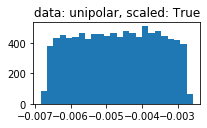

progressive accuracy=========>


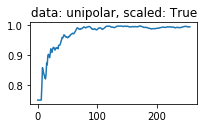

--- 0.5379998683929443 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: 0.0 max: 0.0 RMSE:  0.0
error distribution=========>


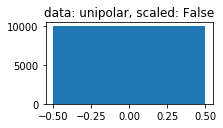

progressive accuracy=========>


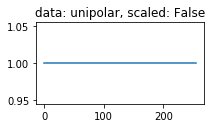

In [6]:
rng = "LFSR"
in_feature = 512
out_feature = 10000
bitwidth = 8
bias = True
linear_test(rng, in_feature, out_feature, bitwidth, bias)

--- 0.7380023002624512 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.010406910441815853 max: -0.001148127019405365 RMSE:  0.006152613554149866
error distribution=========>


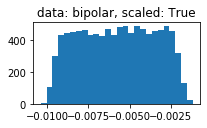

progressive accuracy=========>


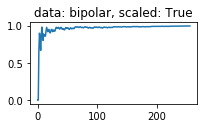

--- 0.7330002784729004 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -1.8984375 max: 1.59375 RMSE:  0.5472262501716614
error distribution=========>


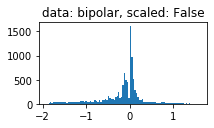

progressive accuracy=========>


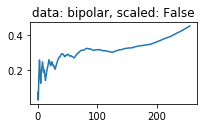

--- 0.5180001258850098 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: -0.005537152290344238 max: -0.0012073814868927002 RMSE:  0.0035819110926240683
error distribution=========>


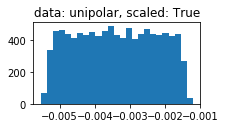

progressive accuracy=========>


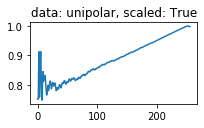

--- 0.5240001678466797 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: 0.0 max: 0.0 RMSE:  0.0
error distribution=========>


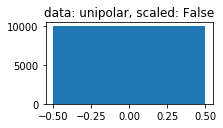

progressive accuracy=========>


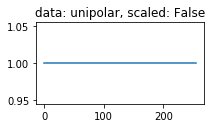

In [7]:
rng = "Race"
in_feature = 512
out_feature = 10000
bitwidth = 8
bias = True
linear_test(rng, in_feature, out_feature, bitwidth, bias)

--- 0.8310031890869141 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.01058855839073658 max: -0.0015670154243707657 RMSE:  0.0064737326465547085
error distribution=========>


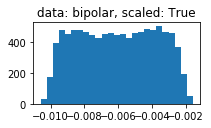

progressive accuracy=========>


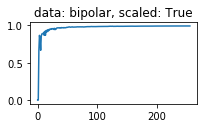

--- 0.8330011367797852 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -1.359375 max: 0.3359375 RMSE:  0.3235172927379608
error distribution=========>


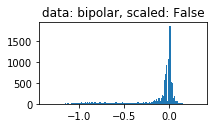

progressive accuracy=========>


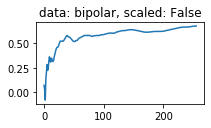

--- 0.5830020904541016 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: -0.005557924509048462 max: -0.0012251734733581543 RMSE:  0.003534829942509532
error distribution=========>


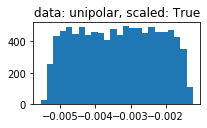

progressive accuracy=========>


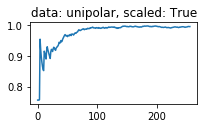

--- 0.5539994239807129 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: 0.0 max: 0.0 RMSE:  0.0
error distribution=========>


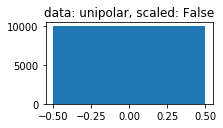

progressive accuracy=========>


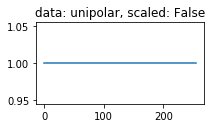

In [8]:
rng = "SYS"
in_feature = 512
out_feature = 10000
bitwidth = 8
bias = True
linear_test(rng, in_feature, out_feature, bitwidth, bias)